In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import librosa
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind, mannwhitneyu, skew, kurtosis, f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from joblib import Parallel, delayed

In [3]:
from utils import load_config, perform_statistical_tests
from data.load.data_loader import get_codecfake_audio_id_list, load_audio_data
from features import (
    LowLevelFeatureExtractor, 
    HighLevelFeatureExtractor, 
    plot_low_level_feature_dist, 
    plot_high_level_feature_dist, 
    perform_pca_and_plot
)

In [4]:
config    = load_config()
cache_dir = config['data_paths']['codecfake']['cache_files']
audio_ids = get_codecfake_audio_id_list()

In [5]:
iterable_ds = load_audio_data(
    audio_ids=audio_ids[:500],
    dataset='codecfake',
    cache_dir=cache_dir
)

In [6]:
rows = []
for audio in iterable_ds:
    audio_id  = audio['audio_id']
    audio_arr = audio['audio']['array']
    srate     = audio['audio']['sampling_rate']
    real_fake = audio['real_or_fake']

    rows.append({
        'audio_id': audio_id,
        'audio_arr': audio_arr,
        'srate': srate,
        'real_or_fake': real_fake
    })

In [7]:
df = pd.DataFrame(rows)
df.head()

,audio_id,audio_arr,srate,real_or_fake
0,p225_002,"[-0.0045166015625, -0.00665283203125, -0.00607...",48000,R
1,p225_002,"[0.001953125, 0.001556396484375, 0.00164794921...",16000,F03
2,p225_002,"[-0.001220703125, -0.001129150390625, -0.00103...",24000,F04
3,p225_002,"[0.001861572265625, 0.001922607421875, 0.00195...",16000,F01
4,p225_002,"[-0.00335693359375, -0.0032958984375, -0.00320...",48000,F05


### Detailed Low Level Features

In [8]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])

In [77]:
low_level_features   = pd.DataFrame(list(audio_processor.low_level_feature_generator(df.iloc[:20])))
low_level_feature_df = pd.DataFrame(low_level_features)
low_level_feature_df.head()

Processing Audios: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


,audio_id,real_or_fake,f0,energy,speaking_rate,pauses,formants
0,p225_002,R,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.002709378, 0.0040384317, 0.0044281585, 0.00...",123.193167,"[(0.0, 1.0973333333333333), (1.625333333333333...","{'F1_mean': 879.0069982463549, 'F1_stdev': 417..."
1,p225_002,F03,"[0.0, 0.0, 0.0, 65.40639132514966, 65.40639132...","[0.0014545178, 0.0026531352, 0.00296167, 0.002...",123.039216,"[(0.0, 1.088), (2.3200000000000003, 2.552), (3...","{'F1_mean': 893.3805848953405, 'F1_stdev': 412..."
2,p225_002,F04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.002566633, 0.0037462886, 0.004179004, 0.003...",123.196721,"[(0.0, 1.0893333333333333), (1.625333333333333...","{'F1_mean': 872.0603492791237, 'F1_stdev': 420..."
3,p225_002,F01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.002960994, 0.005014162, 0.0052305344, 0.005...",122.859353,"[(0.0, 0.7770625000000002), (1.289062500000000...","{'F1_mean': 863.8373523983494, 'F1_stdev': 456..."
4,p225_002,F05,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0019256319, 0.002847619, 0.0031519828, 0.00...",123.076923,"[(0.0, 1.09125), (1.62725, 1.77925), (2.331250...","{'F1_mean': 900.8769212847095, 'F1_stdev': 429..."


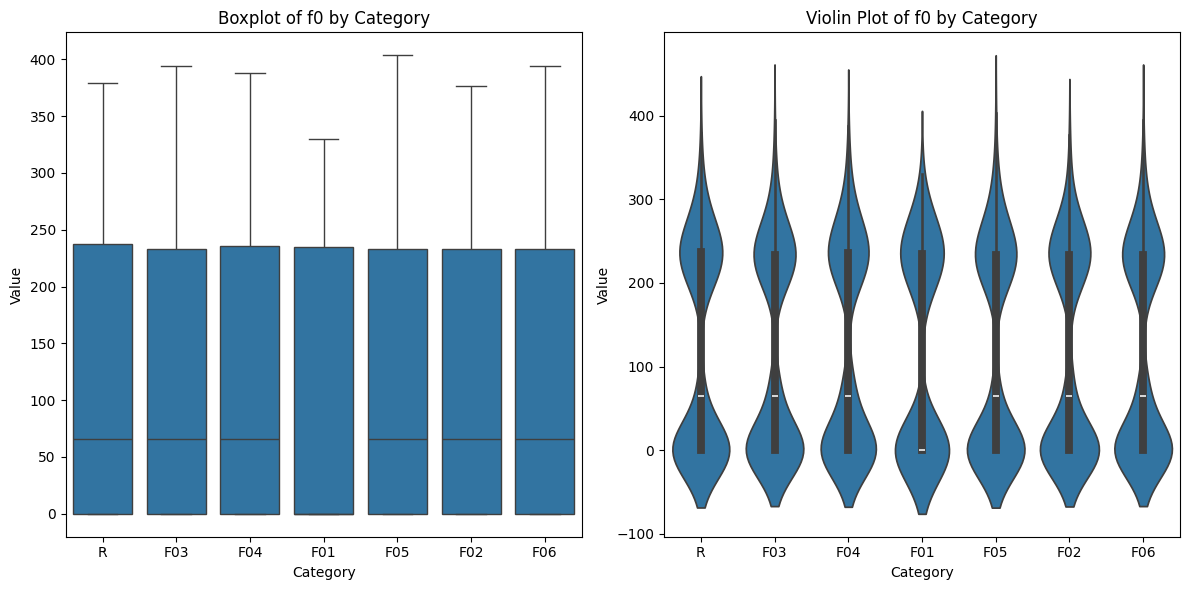

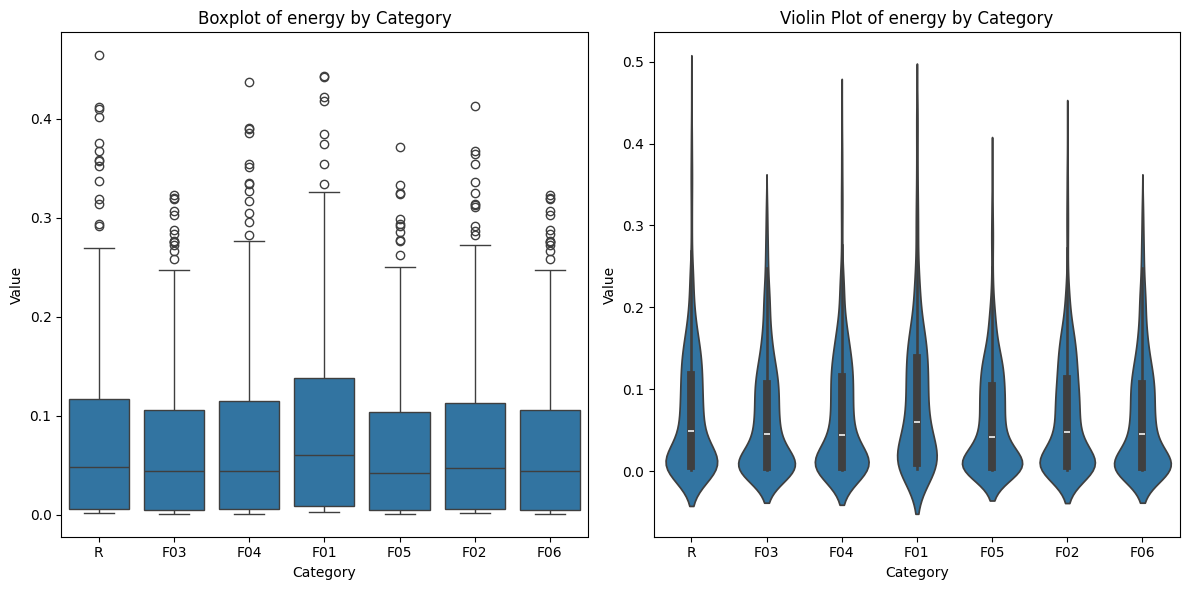

In [78]:
low_level_feature_df = pd.DataFrame(low_level_features)
for feature in [col for col in low_level_feature_df.columns if col not in ['audio_id', 'real_or_fake']]:
    if isinstance(low_level_feature_df[feature].iloc[0], np.ndarray):
        plot_low_level_feature_dist(low_level_feature_df, feature)

**No Obvious/Significant Difference in the distribution of detailed low level features**

In [17]:
del low_level_features
del low_level_feature_df

### Extract High level features

In [18]:
audio_processor = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])
feature_computer = HighLevelFeatureExtractor()

In [19]:
low_level_gen        = audio_processor.low_level_feature_generator(df.iloc[:2])
high_level_features  = list(feature_computer.high_level_feature_generator(low_level_gen))
high_level_features_df = pd.DataFrame(high_level_features)
high_level_features_df

Processing Audios: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


,audio_id,real_or_fake,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_range,f0_25th_percentile,f0_50th_percentile,...,pause_50th_percentile,pause_75th_percentile,pause_skew,pause_kurtosis,F1_mean,F1_stdev,F2_mean,F2_stdev,F3_mean,F3_stdev
0,p225_002,R,117.245567,120.663301,14559.632316,0.0,314.742105,314.742105,0.0,65.406391,...,0.184,0.549,1.033202,-0.538512,879.006998,417.389188,1865.366701,481.127460,3049.531361,494.567763
1,p225_002,F03,116.121114,113.387427,12856.708545,0.0,314.742105,314.742105,0.0,65.406391,...,0.452,0.776,0.399513,-1.444583,893.380585,412.947344,1919.740418,517.426171,3043.040662,519.790781


**Using Parallel Processing**

In [20]:
def extract_features(row, audio_processor, feature_computer):
    low_level_features = audio_processor.extract_features(row)
    high_level_features = feature_computer.compute_high_level_features(low_level_features)
    return high_level_features


In [27]:
audio_processor  = LowLevelFeatureExtractor(target_sr=16000, include_only=['prosodic'])
feature_computer = HighLevelFeatureExtractor()

high_level_features   = Parallel(n_jobs=4)(delayed(extract_features)(row, audio_processor, feature_computer) for _, row in df.iterrows())
high_level_feature_df = pd.DataFrame(high_level_features)
high_level_feature_df

,audio_id,real_or_fake,f0_mean,f0_std,f0_var,f0_min,f0_max,f0_range,f0_25th_percentile,f0_50th_percentile,...,pause_50th_percentile,pause_75th_percentile,pause_skew,pause_kurtosis,F1_mean,F1_stdev,F2_mean,F2_stdev,F3_mean,F3_stdev
0,p225_002,R,117.245567,120.663301,14559.632316,0.0,314.742105,314.742105,0.0,65.406391,...,0.184000,0.549000,1.033202,-0.538512,879.006998,417.389188,1865.366701,481.127460,3049.531361,494.567763
1,p225_002,F03,116.121114,113.387427,12856.708545,0.0,314.742105,314.742105,0.0,65.406391,...,0.452000,0.776000,0.399513,-1.444583,893.380585,412.947344,1919.740418,517.426171,3043.040662,519.790781
2,p225_002,F04,115.053118,116.403448,13549.762727,0.0,312.929324,312.929324,0.0,65.406391,...,0.224000,0.665333,0.757199,-1.058346,872.060349,420.902274,1934.400402,567.486336,3065.190896,526.464769
3,p225_002,F01,131.467468,120.080233,14419.262410,0.0,318.399232,318.399232,0.0,212.505992,...,0.152000,0.276531,1.639249,1.199459,863.837352,456.161353,1883.299939,469.954775,3026.219415,501.378510
4,p225_002,F05,113.173705,120.912706,14619.882442,0.0,316.565388,316.565388,0.0,0.000000,...,0.216000,0.659250,0.771103,-1.036190,900.876921,429.242978,1936.676910,495.388133,3070.330027,497.115083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,p227_037,R,22.877084,53.107320,2820.387465,0.0,179.730700,179.730700,0.0,0.000000,...,0.289234,0.598469,0.907272,-0.899108,1034.187849,465.361091,2131.035786,547.180166,3188.454815,447.833566
3496,p227_037,F05,40.520006,67.594174,4568.972332,0.0,217.473084,217.473084,0.0,0.000000,...,0.224000,0.520875,1.095950,-0.414487,979.036741,424.197332,2090.877868,506.752196,3172.114080,425.698193
3497,p227_037,F01,26.894447,58.841845,3462.362676,0.0,182.872337,182.872337,0.0,0.000000,...,0.196531,0.360266,1.141455,-0.676798,983.825303,486.612226,2082.406548,564.856983,3137.924622,535.900156
3498,p227_037,F06,27.293393,55.773550,3110.688835,0.0,178.695527,178.695527,0.0,0.000000,...,0.296000,0.616000,0.876522,-0.933949,967.226553,439.546893,2052.610288,519.138302,3114.526501,481.245274


In [65]:
high_level_feature_df.isna().sum()

audio_id                   0
real_or_fake               0
f0_mean                    0
f0_std                     0
f0_var                     0
f0_min                     0
f0_max                     0
f0_range                   0
f0_25th_percentile         0
f0_50th_percentile         0
f0_75th_percentile         0
f0_skew                   16
f0_kurtosis               16
energy_mean                0
energy_std                 0
energy_var                 0
energy_min                 0
energy_max                 0
energy_range               0
energy_25th_percentile     0
energy_50th_percentile     0
energy_75th_percentile     0
energy_skew                0
energy_kurtosis            0
speaking_rate              0
pause_mean                 3
pause_std                  3
pause_var                  3
pause_min                  3
pause_max                  3
pause_range                3
pause_25th_percentile      3
pause_50th_percentile      3
pause_75th_percentile      3
pause_skew    

In [28]:
stats_df = perform_statistical_tests(high_level_feature_df)
stats_df

,feature,t_stat,t_p_val,u_stat,u_p_val,effect_size,f_stat,f_p_val
0,f0_mean,-2.091216,3.688102e-02,704223.5,2.865511e-02,-0.100952,4.362173,3.681753e-02
1,f0_std,0.646521,5.181607e-01,781340.5,1.341009e-01,0.031170,0.414802,5.195843e-01
2,f0_var,0.576104,5.647287e-01,781340.5,1.341009e-01,0.027111,0.299744,5.840782e-01
3,f0_max,-0.227143,8.203810e-01,752496.5,9.050223e-01,-0.010921,0.050637,8.219719e-01
4,f0_range,-0.227143,8.203810e-01,752496.5,9.050223e-01,-0.010921,0.050637,8.219719e-01
5,f0_25th_percentile,-2.064381,3.930273e-02,738981.0,1.641521e-01,-0.090528,2.986820,8.403313e-02
6,f0_50th_percentile,-4.800712,1.931487e-06,640021.0,1.440994e-08,-0.225943,20.822623,5.211542e-06
7,f0_75th_percentile,-0.214505,8.302190e-01,745396.0,8.258015e-01,-0.010461,0.047827,8.269017e-01
8,f0_skew,2.307930,2.130533e-02,790272.0,1.485387e-02,0.111447,5.223665,2.234138e-02
9,f0_kurtosis,-0.192516,8.473968e-01,722332.0,4.000239e-01,-0.009340,0.037033,8.474100e-01


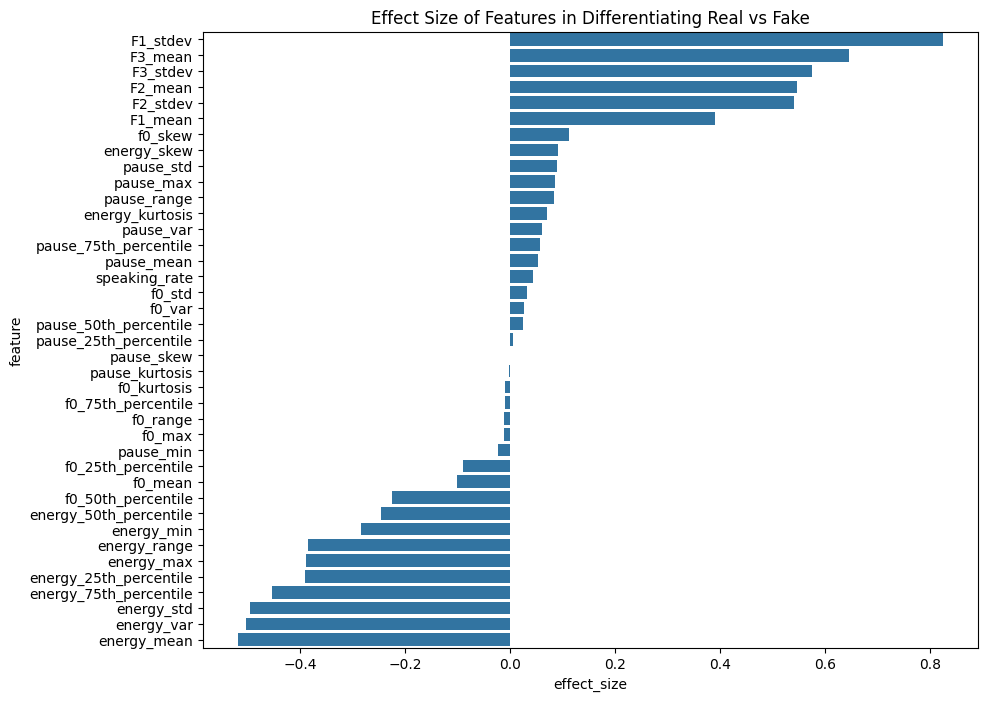

In [29]:
# Visualize the results
plt.figure(figsize=(10, 8))
sns.barplot(x='effect_size', y='feature', data=stats_df.sort_values(by='effect_size', ascending=False))
plt.title('Effect Size of Features in Differentiating Real vs Fake')
plt.show()

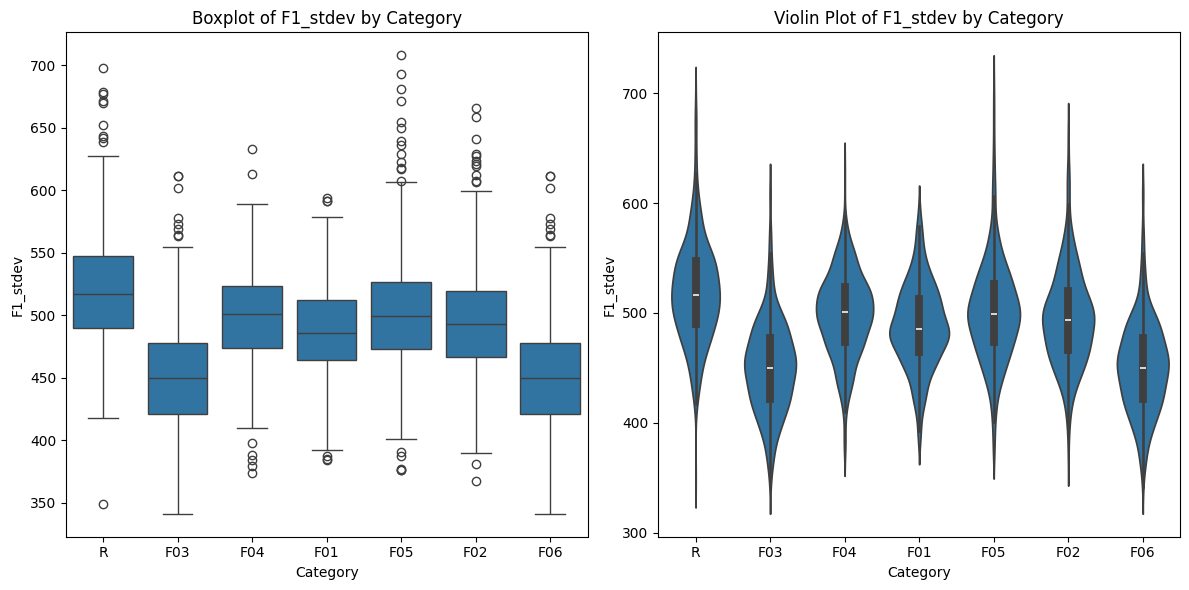

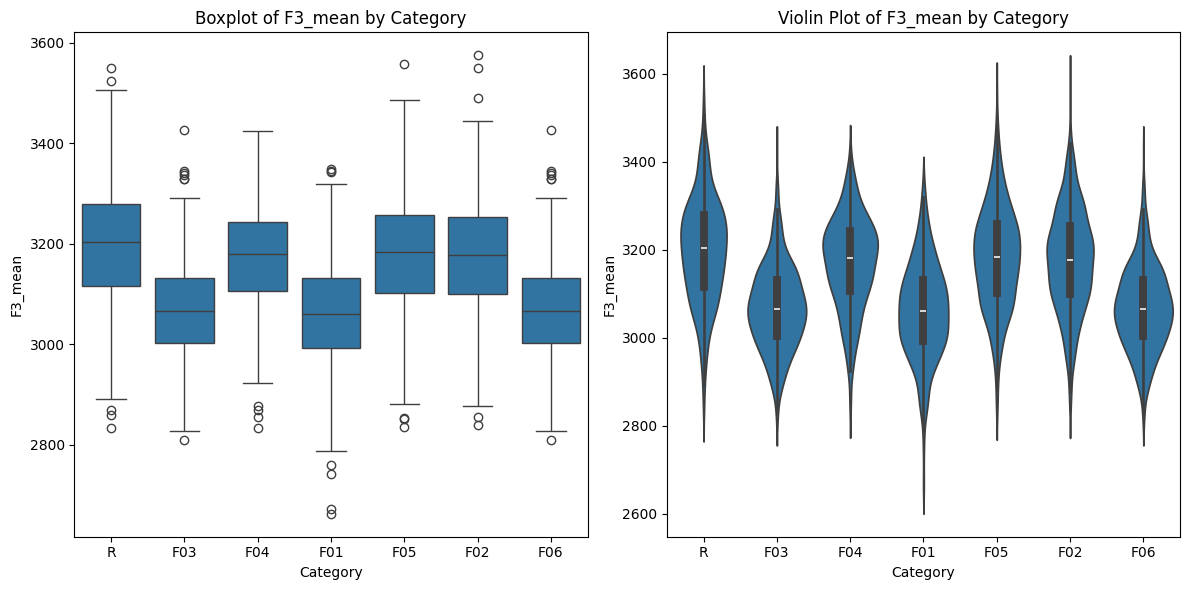

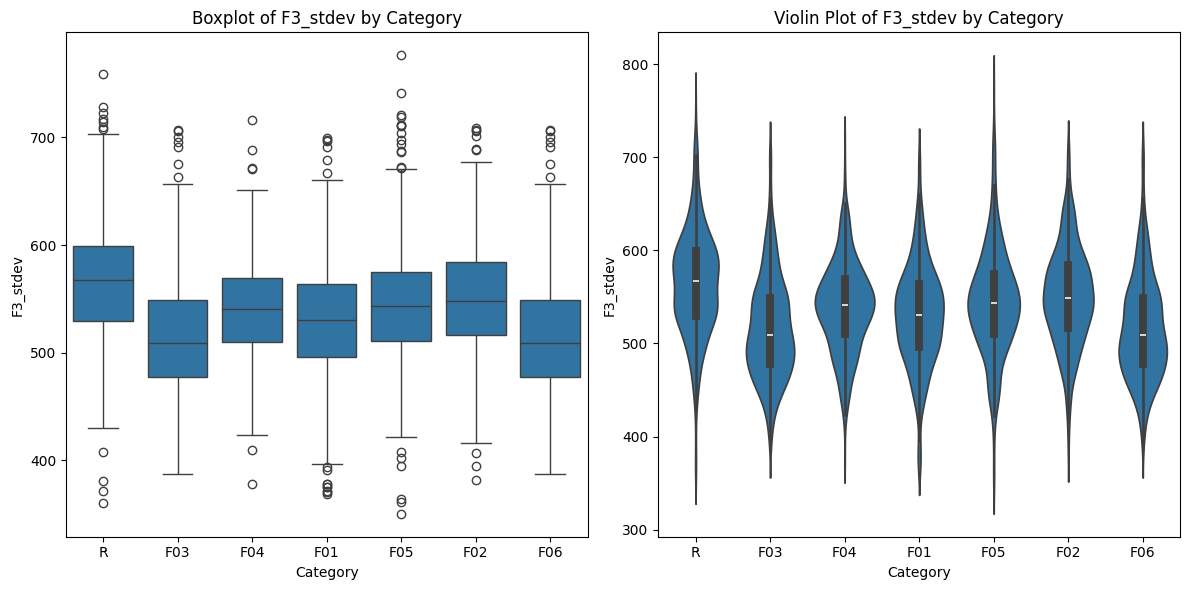

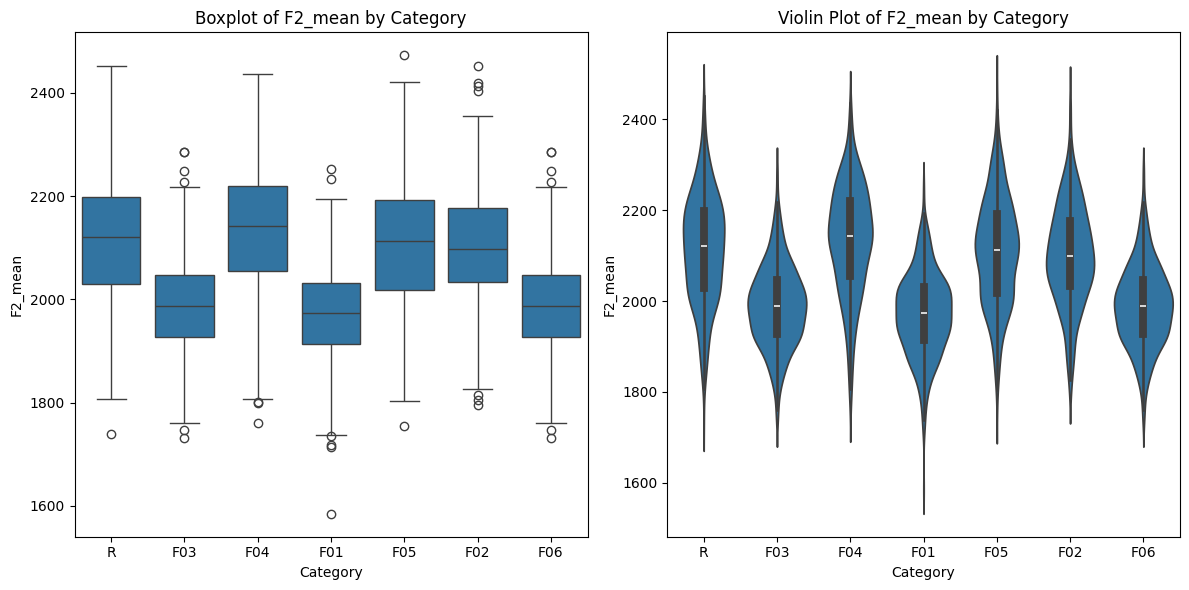

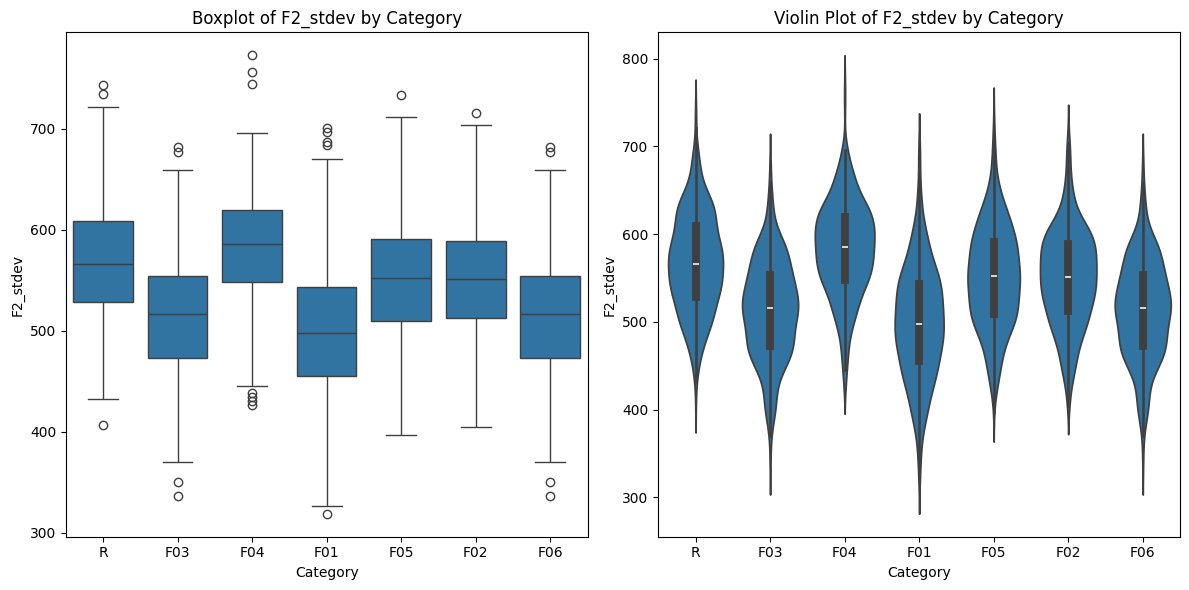

In [30]:
all_features = stats_df.sort_values(by=['effect_size'], ascending=False).feature.tolist()
plot_high_level_feature_dist(high_level_feature_df, all_features[:5])

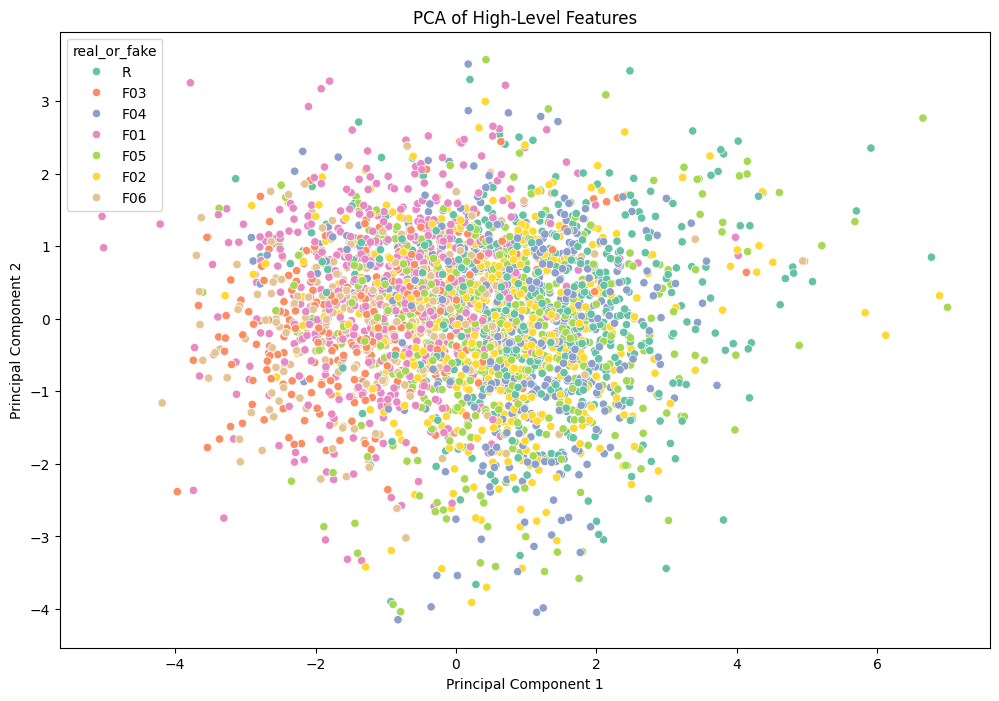

In [52]:
perform_pca_and_plot(high_level_feature_df, all_features[:5])

In [53]:
def logistic_regression_feature_importance(df, selected_features, target_column='real_or_fake'):
    # Drop columns with NaN values
    df_clean = df.dropna(axis=1)
    
    # Ensure selected features are in the cleaned DataFrame
    selected_features = [feature for feature in selected_features if feature in df_clean.columns]

    X = df_clean[selected_features]
    y = df_clean[target_column].apply(lambda x: 1 if x == 'R' else 0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression()
    model.fit(X_scaled, y)
    
    feature_importances = model.coef_[0]
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)

    return importance_df

importance_df = logistic_regression_feature_importance(high_level_feature_df, all_features)
importance_df

,feature,importance
1,F3_mean,1.940984
23,energy_std,1.083042
0,F1_stdev,0.966051
2,F3_stdev,0.416556
9,f0_std,0.398164
17,energy_50th_percentile,0.351111
20,energy_max,0.347808
19,energy_range,0.347615
10,f0_var,0.326768
7,energy_kurtosis,0.196400


### Redundant Features

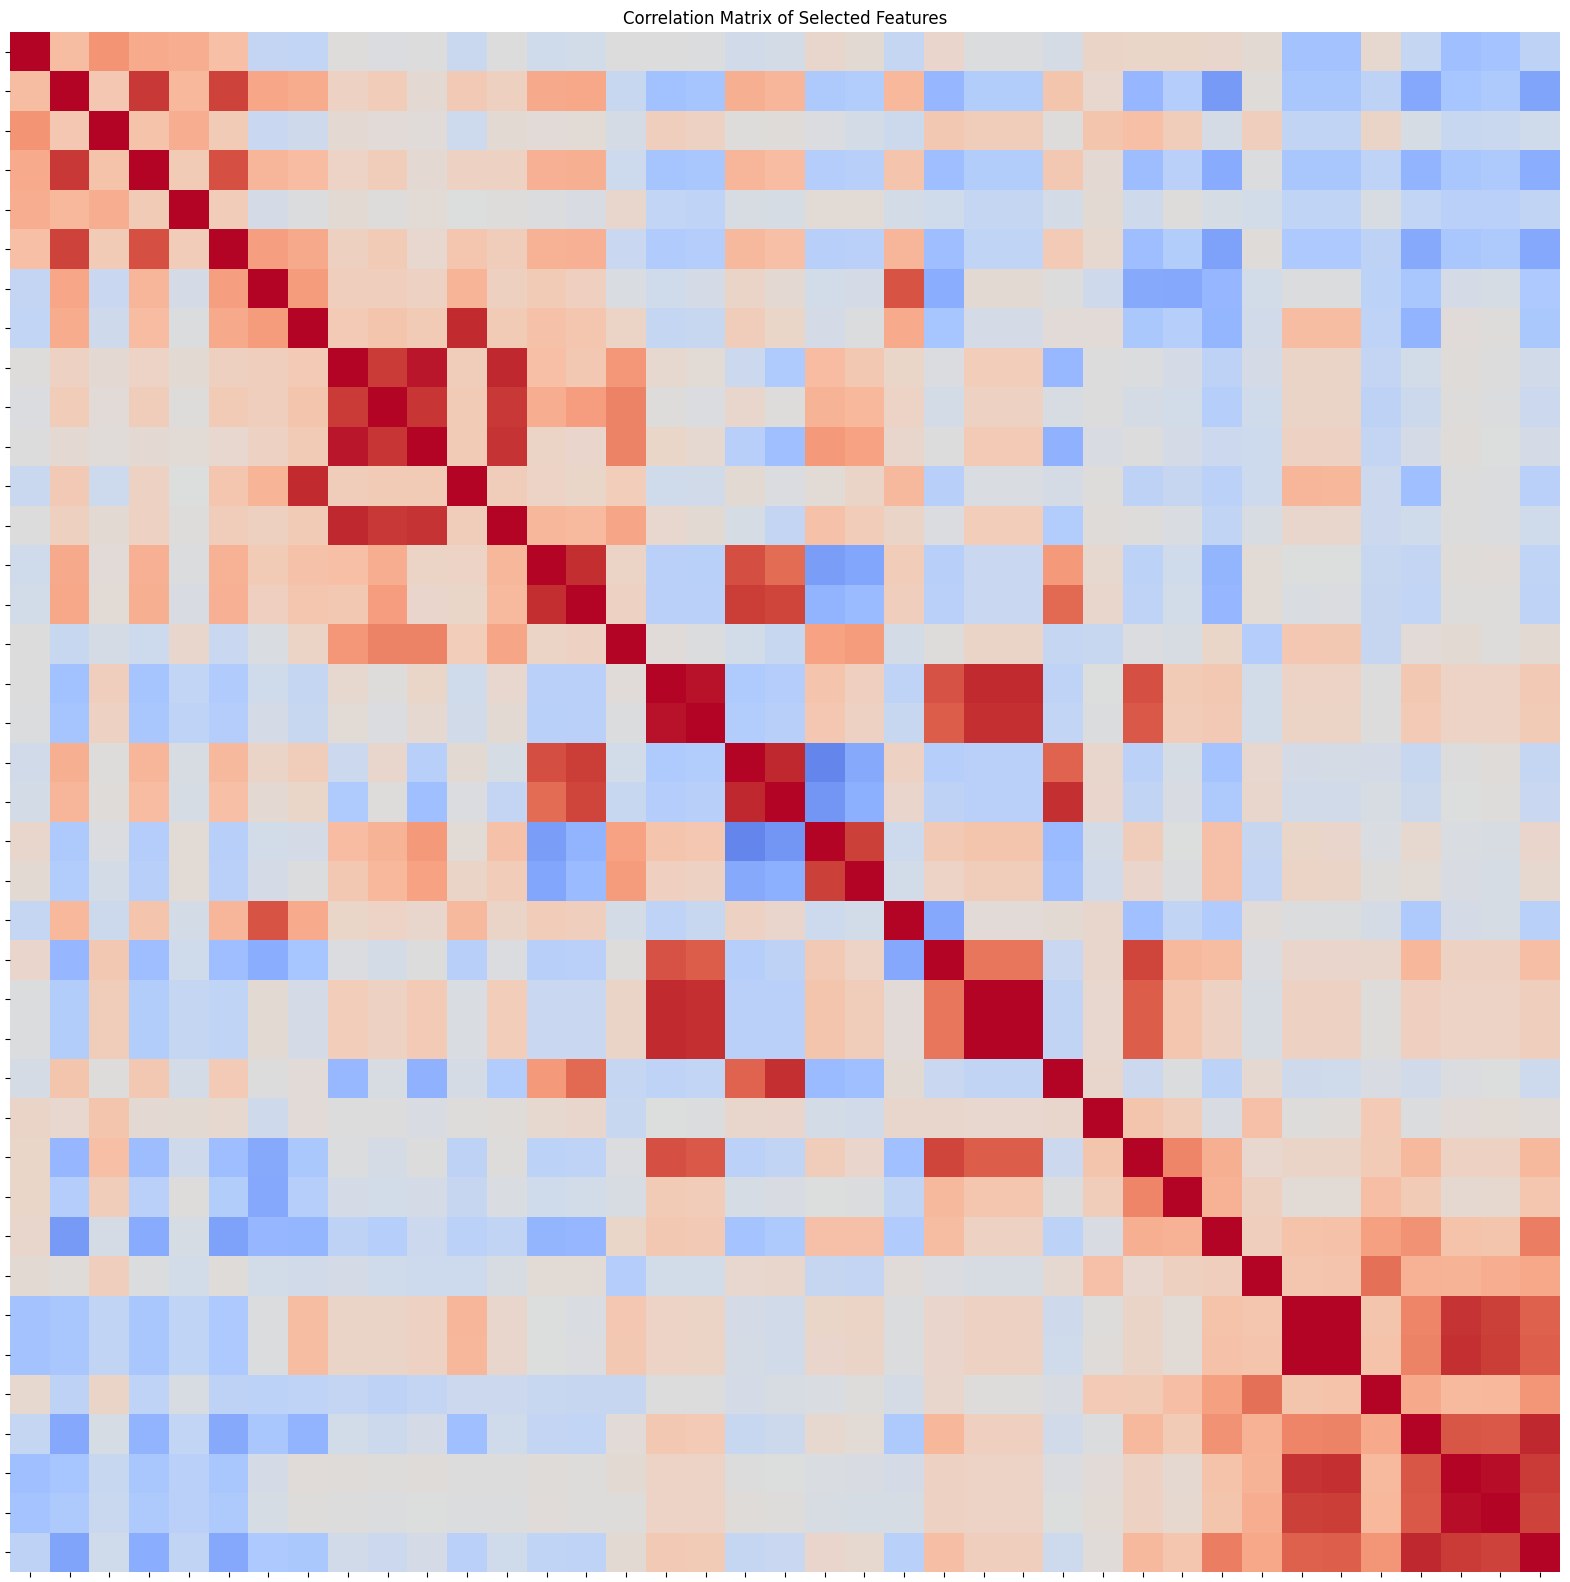

In [54]:
def compute_correlation_matrix(df, selected_features):
    return df[selected_features].corr()

correlation_matrix = compute_correlation_matrix(high_level_feature_df, all_features)

plt.figure(figsize=(20, 20))
ax = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [55]:
def remove_highly_correlated_features(df, selected_features, threshold=0.6):
    correlation_matrix = df[selected_features].corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    # Remove redundant features
    reduced_features = [feature for feature in selected_features if feature not in to_drop]

    return reduced_features


reduced_features = remove_highly_correlated_features(high_level_feature_df, all_features)
print(f"Reduced Features: {reduced_features}")


Reduced Features: ['F1_stdev', 'F3_mean', 'F3_stdev', 'F2_stdev', 'f0_skew', 'energy_skew', 'pause_std', 'pause_75th_percentile', 'f0_std', 'f0_25th_percentile', 'f0_50th_percentile', 'energy_min', 'energy_range']


In [56]:
high_level_feature_df[reduced_features].dropna().isna().sum()

F1_stdev                 0
F3_mean                  0
F3_stdev                 0
F2_stdev                 0
f0_skew                  0
energy_skew              0
pause_std                0
pause_75th_percentile    0
f0_std                   0
f0_25th_percentile       0
f0_50th_percentile       0
energy_min               0
energy_range             0
dtype: int64

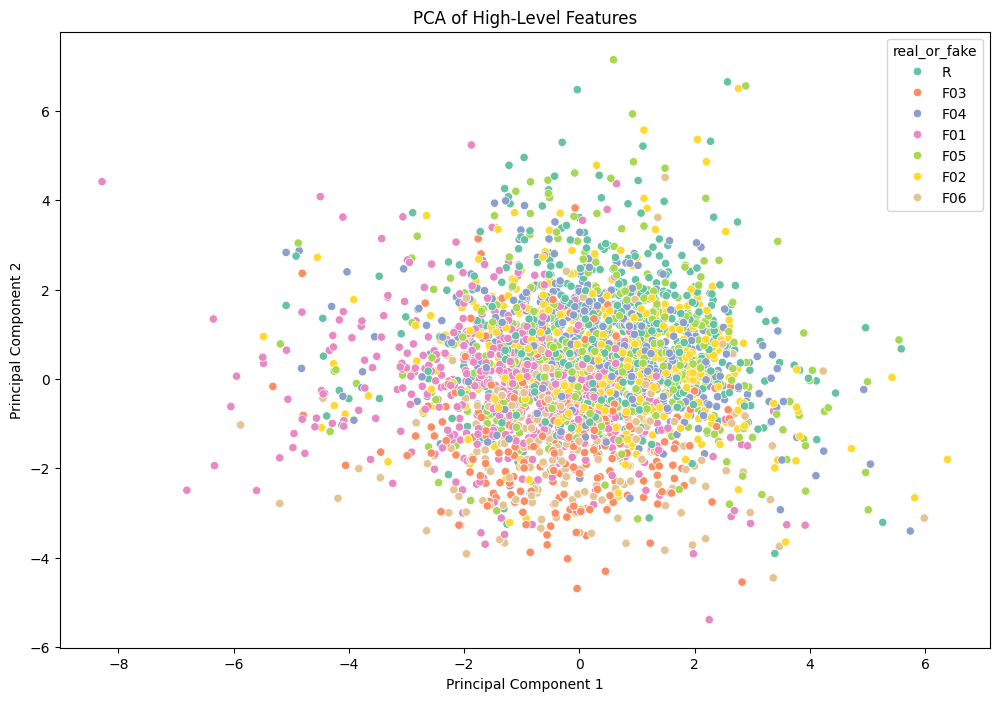

In [59]:
perform_pca_and_plot(high_level_feature_df, reduced_features)

In [71]:
importance_df = logistic_regression_feature_importance(high_level_feature_df, reduced_features)
importance_df

,feature,importance
0,F1_stdev,0.679675
1,F3_mean,0.569339
2,F3_stdev,0.248948
9,energy_range,0.183851
5,f0_std,0.180279
3,F2_stdev,0.127692
4,energy_skew,-0.073606
6,f0_25th_percentile,-0.311458
7,f0_50th_percentile,-0.312335
8,energy_min,-0.417052


### Baseline Model

In [72]:
good_features = reduced_features
imputer = SimpleImputer(strategy='mean')

In [73]:
X = high_level_feature_df[good_features]
X = imputer.fit_transform(X)
y = high_level_feature_df['real_or_fake'].apply(lambda x: 1 if x == 'R' else 0)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Fake', 'Real'])
    
    model_performance[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Classification Report': report
    }


for model_name, metrics in model_performance.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("Classification Report:\n", metrics['Classification Report'])
    print("-" * 60)


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.8400
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

        Fake       0.84      1.00      0.91       590
        Real       0.00      0.00      0.00       110

    accuracy                           0.84       700
   macro avg       0.42      0.50      0.46       700
weighted avg       0.71      0.84      0.77       700

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8400
Precision: 0.4286
Recall: 0.0545
F1 Score: 0.0968
Classification Report:
               precision    recall  f1-score   support

        Fake       0.85      0.99      0.91       590
        Real       0.43      0.05      0.10       110

    accuracy                           0.84       700
   macro avg       0.64      0.52      0.50       700
weighted avg       0.78      0.84      0.78       700

-------------------------------------------------------